To open on Google Colab [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week7/gd_torch.ipynb)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd

/usr/local/anaconda3/envs/chem4pb3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Linear model (recap)

In the previous lectures, we studied linear model,\
$f_{\phi(\cdot)}(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x}) = \sum_i w_i \phi_i(\mathbf{x})$.

* $\phi(\cdot)$ is the linear map to a new **feature representation**, for example, polynomials, Fourier basis, ec.

For a square loss function, $ {\cal L} \approx \|\mathbf{y} - f_{\phi(\cdot)}(\mathbf{X}) \|_2$, the optimal parameters $\mathbf{w}^*$ can be obtained in closed form.\

$\mathbf{w}^* = \Big( \Phi(\mathbf{X})^\top\Phi(\mathbf{X})\Big)^{-1} \Phi(\mathbf{X})^\top\mathbf{y}$.

Theoretically, the bottleneck to solve for $\mathbf{w}^*$ relies on inverting the matrix $\Big( \Phi(\mathbf{X})^\top\Phi(\mathbf{X})\Big)$.\
Matrix inversion is one of the most **expensive operations**, ${\cal O}(N^3)$ where $N$ is this case is the number of training points.

Let's assume we have a **GIGANTIC** dataset, $N \approx 100,000$ points. 
It will computationally demanding to solve for $\mathbf{w}^*$. 

However, the gradient of ${\cal L}(\mathbf{w})$ with respect to $\mathbf{w}$ scales **quadratically**,\
$\nabla {\cal L}(\mathbf{w}) = \Phi(\mathbf{X})^\top\Phi(\mathbf{X})\mathbf{w} -\Phi(\mathbf{X})^\top\mathbf{y}$\
Matrix-matrix multiplication $(\Phi(\mathbf{X})^\top\Phi(\mathbf{X}))$ scales  ${\cal O}(N^2)$, (**one order of magnitude lower**).


* **$N = 100, \;\; N^2 = 10,000, \;\; N^3 = 1,000,000$**


## Gradient descent

We can search for the minimum/maximum of $\nabla {\cal L}(\mathbf{w})$ using gradient-based methods.\
For example, for $f(x_0,x_1) = x_0^2 + x_1^2$, 

In [2]:
f_sqr = lambda x:np.sum(np.power(x,2),axis=1)
x = np.linspace(-2., 2., 50)
x0,x1 = np.meshgrid(x,x)
X = np.column_stack((x0.flatten(),x1.flatten()))
y = f_sqr(X)
y = y.reshape((x0.shape))

Text(0, 0.5, '$x_1$')

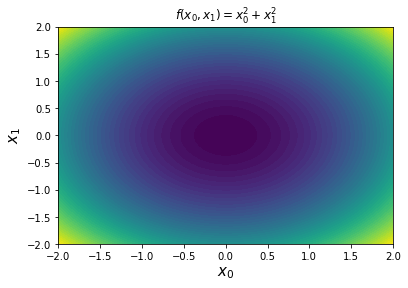

In [3]:
plt.title(f'$f(x_0,x_1) = x_0^2 + x_1^2$')
plt.contourf(x0, x1, y, levels=60)
plt.xlabel(f'$x_0$', fontsize=15)
plt.ylabel(f'$x_1$', fontsize=15)

# Gradients 
The gradient (Jacobian) of $f(x_0,x_1) = x_0^2 + x_1^2$ is,\
$\frac{\partial f}{\partial x_0} = 2x_0$ and $\frac{\partial f}{\partial x_1} = 2x_1$.\
Meaning, $\nabla f(x_0,x_1) = [2x_0,2x_1]$

At any given point, $\nabla f(x_0,x_1)$ tells you the direction in which the function changes with the greatest rate.\
If you think of the function as height, then it gives the direction in which the ground is steepest.

In [4]:
grad_f_sqr = lambda x:2*x

gx = np.random.uniform(low=-0.75,high=0.75,size=(10,2))
gx0,gx1 = gx[:,0],gx[:,1]
gX = np.column_stack((gx0.flatten(), gx1.flatten()))
print(gX.shape)
grad = grad_f_sqr(gX)

(10, 2)


/var/folders/t5/4s883lqs43gbc9km4ykw_y7w0000gn/T/ipykernel_48085/2557161983.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contourf(x0, x1, y, lw=2, levels=60)


Text(0, 0.5, '$\\frac{\\partial f}{\\partial x_{1}}$')

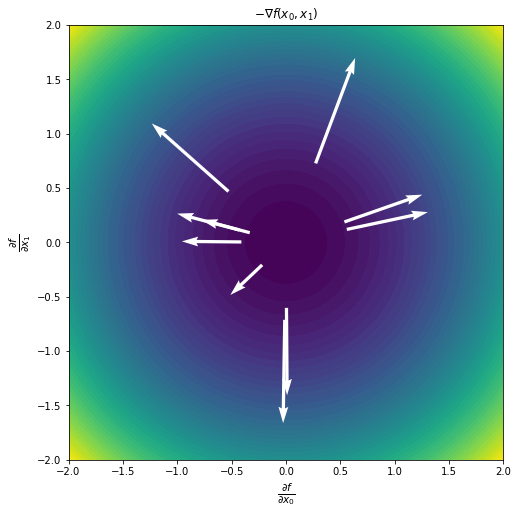

In [5]:
# gradient field
fig, ax = plt.subplots(1, 1,figsize=(8,8))
ax.set_aspect(1)
# ax.plot(feature_x, feature_y, c='k')
gf_x0 = grad[:,0].reshape(gx0.shape)
gf_x1 = grad[:,1].reshape(gx1.shape)
ax.contourf(x0, x1, y, lw=2, levels=60)

eta = 0.1 #rescale
ax.quiver(gx0, gx1, eta*gf_x0, eta*gf_x1,
          units='xy', scale=0.15, color='white')
ax.set_aspect('equal')
ax.set_title(r'$-\nabla f(x_0,x_1)$')
ax.set_xlabel(r'$\frac{\partial f}{\partial x_{0}}$', fontsize=15)
ax.set_ylabel(r'$\frac{\partial f}{\partial x_{1}}$', fontsize=15)


# Minimum search using gradient descent
Algorithm
1. Start with a random initial value of $x_0$ and $x_1$; $[x_0,x_1]_{t}$
2. Compute the gradient; $\nabla f(x_0,x_1) = \nabla f([x_0,x_1]_{t})$
3. Update $x_0$ and $x_1$ using the information from step 2.
    * $[x_0,x_1]_{t+1} = [x_0,x_1]_t - \eta \nabla f(x_0,x_1)$ 
  * $\eta$ is known as the step size or **learning rate**
1. Repeat until convergence criteria is is satisfied:
    * $\|\nabla f(x_0,x_1) \| < 10^{-6}$
    *  $\| f([x_0,x_1]_{t+1}) - f([x_0,x_1]_{t})\| < 10^{-6} $
 * $10^{-6}$ is a threshold  parameter, and is problem dependent.

In [6]:
# gradient descent algorithm
x = np.random.uniform(-2.,2.,(1,2))
eta = 0.1

x_trajectory = np.zeros_like(x.ravel())
g_trajectory = np.zeros_like(x.ravel())
f_trajectory = np.zeros(1)
c = 1E-4
xt = x
for t in range(20):
    grad_t = grad_f_sqr(xt)
    y_t = f_sqr(xt)
    g_trajectory = np.vstack((g_trajectory,grad_t))
    f_trajectory = np.append(f_trajectory, y_t)
    x_trajectory = np.vstack((x_trajectory, xt))
    print('t = %s, f = %.4f, '%(t,y_t),'x = ', x   ,'g = ', grad_t)
    xt = xt - eta*grad_t
    
    if np.linalg.norm(g_trajectory[-2] - g_trajectory[-1]) < c or np.linalg.norm(f_trajectory[-2] - f_trajectory[-1]) < c:
        break

# remove initial useless point.
g_trajectory = g_trajectory[1:]
f_trajectory = f_trajectory[1:]
x_trajectory = x_trajectory[1:]

t = 0, f = 1.9891,  x =  [[-0.98533363  1.00905428]] g =  [[-1.97066726  2.01810855]]
t = 1, f = 1.2730,  x =  [[-0.98533363  1.00905428]] g =  [[-1.57653381  1.61448684]]
t = 2, f = 0.8147,  x =  [[-0.98533363  1.00905428]] g =  [[-1.26122705  1.29158947]]
t = 3, f = 0.5214,  x =  [[-0.98533363  1.00905428]] g =  [[-1.00898164  1.03327158]]
t = 4, f = 0.3337,  x =  [[-0.98533363  1.00905428]] g =  [[-0.80718531  0.82661726]]
t = 5, f = 0.2136,  x =  [[-0.98533363  1.00905428]] g =  [[-0.64574825  0.66129381]]
t = 6, f = 0.1367,  x =  [[-0.98533363  1.00905428]] g =  [[-0.5165986   0.52903505]]
t = 7, f = 0.0875,  x =  [[-0.98533363  1.00905428]] g =  [[-0.41327888  0.42322804]]
t = 8, f = 0.0560,  x =  [[-0.98533363  1.00905428]] g =  [[-0.3306231   0.33858243]]
t = 9, f = 0.0358,  x =  [[-0.98533363  1.00905428]] g =  [[-0.26449848  0.27086594]]
t = 10, f = 0.0229,  x =  [[-0.98533363  1.00905428]] g =  [[-0.21159879  0.21669276]]
t = 11, f = 0.0147,  x =  [[-0.98533363  1.00905428]]

/var/folders/t5/4s883lqs43gbc9km4ykw_y7w0000gn/T/ipykernel_48085/2643400914.py:6: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contourf(x0, x1, y, lw=2, levels=60)


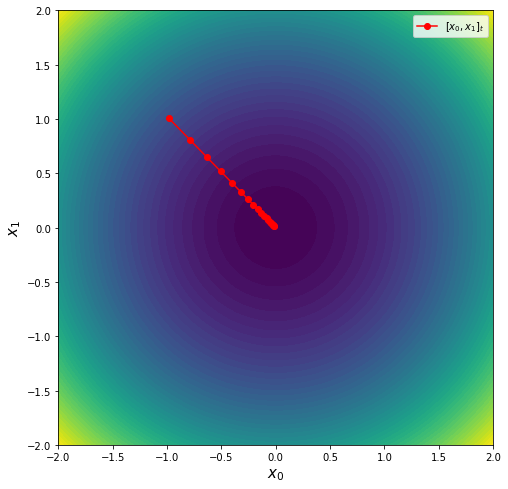

In [7]:
fig, ax = plt.subplots(1, 1,figsize=(8,8))
ax.set_aspect(1)
# ax.plot(feature_x, feature_y, c='k')
gf_x0 = grad[:,0].reshape(gx0.shape)
gf_x1 = grad[:,1].reshape(gx1.shape)
ax.contourf(x0, x1, y, lw=2, levels=60)
ax.plot(x_trajectory[:,0],x_trajectory[:,1],color='red',marker='o',label=r'$[x_0,x_1]_t$')
ax.set_aspect('equal')
ax.set_xlabel(r'$x_0$',fontsize=15)
ax.set_ylabel(r'$x_1$',fontsize=15)
plt.legend()

## What happen when we do not have gradients $\nabla f(\mathbf{x})$?

(extra topic), study [Finite Difference](https://mathworld.wolfram.com/FiniteDifference.html)

Finite Difference --> numerical approximation for gradients and higher order derivatives.

## Let's revise **linear model**,
$f_{\phi(\cdot)}(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x}) = \sum_i w_i \phi_i(\mathbf{x})$.

**Diagram**\
<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/Linear_model_diagram.png"  width="350" height="300">


## Linear model in Torch for Harmonic series

Harmonic series to approximate the Morse function. [**Reference**](https://www.tandfonline.com/doi/full/10.1080/08927020903433739)\
**Morse function**\
$E_{Morse} = D_{e}\left (1-\exp^{-\alpha(r-r_0)} \right )^2$,\
where $\alpha = \sqrt{k/2D_{e}}$.

**Harmonic series**\
$E_{harmonic} = \sum_{\ell=1}^p \frac{k_\ell}{r^{\ell}}$, 
is alternative to the polynomials that approaches to zero as $r$ approaches to infinity.

Computationally, $E_{harmonic}$ is simply a linear model over $[r,r^1,\cdots,r^\ell]$, and the parameters $k_\ell$ are linear weigths.\
(let's code this in torch)

```python
def polynomial(r,ell):
    r = 1/r #power ell = 1
    R = r
    # loop over higher orders
    for i in range(2,ell+1):
        r_l = np.power(r,i)
        R = np.column_stack((R,r_l))
    return R
```

In [8]:
# code in torch
class HarmonicSeries(nn.Module):
    def __init__(self, ell):
        super().__init__()
        self.ell = ell

    def forward(self, x):
        x = torch.div(1,x)
        R = x
        for i in range(2,self.ell+1):
            r_l = x.pow(i)
            R = torch.column_stack((R,r_l))
        return R

In [9]:
class LinearHarmonicModel(nn.Module):
    def __init__(self,ell):
        super().__init__()
        self.ell = ell
        self.harmonic = HarmonicSeries(self.ell)
        self.linear = nn.Linear(self.ell,1)
        nn.init.zeros_(self.linear.weight) #play around with this initialization

    def forward(self, x):
        r = self.harmonic(x)
        y = self.linear(r)
        return y

## Fit N2 PES (again)

In [16]:
#data
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/PES_N2"
data = pd.read_csv(data_url)
X, y = data['R'].to_numpy(), data['Energy'].to_numpy()
X = torch.from_numpy(X).unsqueeze(1).float()
y = (y - np.mean(y))/np.std(y)
y = torch.from_numpy(y).unsqueeze(1).float()
print(X.shape,y.shape)

torch.Size([100, 1]) torch.Size([100, 1])


tensor(1.0296, grad_fn=<MseLossBackward0>)
torch.Size([100, 1])
Parameters
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       requires_grad=True)
Parameter containing:
tensor([-0.1721], requires_grad=True)


Text(0, 0.5, 'Energy')

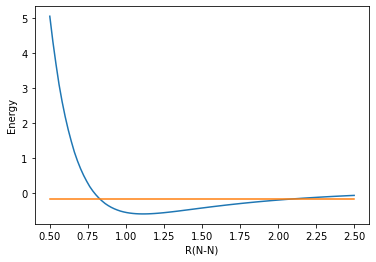

In [17]:
# test our model
model = LinearHarmonicModel(20)
X_rnd = torch.randn((10, 1))
y_pred = model(X)
loss = nn.MSELoss()
print(loss(y_pred,y))
print(y_pred.shape)
print('Parameters')
print(model.linear.weight)
print(model.linear.bias)


plt.plot(X.numpy(),y.numpy())
plt.plot(X.numpy(),model(X).detach().numpy())
plt.xlabel('R(N-N)')
plt.ylabel('Energy')

In [12]:
#define a linear model
m = nn.Linear(10,2) # input dimensions -> output dimensions
print(m.weight)
print(m.bias)
X = torch.randn((5,10))
y = X @ m.weight.T
print(y)

Parameter containing:
tensor([[-0.0635,  0.1805, -0.1947,  0.2345,  0.1007, -0.1105,  0.1434,  0.0980,
          0.0345,  0.1150],
        [-0.0086,  0.2748, -0.2134,  0.2136,  0.2638,  0.2643, -0.0290,  0.1569,
          0.0665, -0.0784]], requires_grad=True)
Parameter containing:
tensor([-0.1979,  0.1837], requires_grad=True)
tensor([[ 0.4778,  0.8050],
        [-0.0809,  0.0640],
        [ 0.0500,  0.5119],
        [-0.1808, -0.1346],
        [ 0.2527,  0.3235]], grad_fn=<MmBackward0>)


In [18]:
# Training

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
loss = nn.MSELoss()

training_iter = 2000
loss_trajectory = []
loss_trajectory_tst = []

l2_lambda = 0.1
for itr in range(1,training_iter):
    output = model(X)
    loss_val = loss(output,y)
    
    # l_norm = sum(p.pow(2.0).sum()
    #               for p in model.parameters())
    l_norm = sum(p.abs().sum()for p in model.parameters())
    
    loss_val = loss_val + l2_lambda*l_norm
    
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    if itr%10 == 0 :
        print(f'itr = %s, loss = %.4f'%(itr,loss_val.item()))

itr = 10, loss = 1525307.8750
itr = 20, loss = 39217.4180
itr = 30, loss = 76940.6641
itr = 40, loss = 74048.0938
itr = 50, loss = 30360.2773
itr = 60, loss = 11125.0322
itr = 70, loss = 3768.4763
itr = 80, loss = 726.9931
itr = 90, loss = 0.4908
itr = 100, loss = 127.5654
itr = 110, loss = 48.9364
itr = 120, loss = 3.4178
itr = 130, loss = 7.8882
itr = 140, loss = 0.9341
itr = 150, loss = 0.6651
itr = 160, loss = 0.5322
itr = 170, loss = 0.1732
itr = 180, loss = 0.1562
itr = 190, loss = 0.1579
itr = 200, loss = 0.1475
itr = 210, loss = 0.1405
itr = 220, loss = 0.1370
itr = 230, loss = 0.1350
itr = 240, loss = 0.1336
itr = 250, loss = 0.1325
itr = 260, loss = 0.1316
itr = 270, loss = 0.1309
itr = 280, loss = 0.1303
itr = 290, loss = 0.1299
itr = 300, loss = 0.1295
itr = 310, loss = 0.1291
itr = 320, loss = 0.1288
itr = 330, loss = 0.1285
itr = 340, loss = 0.1282
itr = 350, loss = 0.1279
itr = 360, loss = 0.1277
itr = 370, loss = 0.1274
itr = 380, loss = 0.1272
itr = 390, loss = 0.1269


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(X.numpy()[::2], y.numpy()[::2], marker='s', markersize=5,label='DFT')

X_grid = torch.linspace(X.min(),X.max(),2000)
X_grid = X_grid.unsqueeze(-1)
plt.plot(X_grid.detach().numpy(), model(X_grid).detach().numpy(),label='Harmonic Series')
plt.xlabel('R(N-N)',fontsize=15)
plt.ylabel('Energy',fontsize=15)
plt.legend()


## Next lecture

## What if $\phi(\cdot)$ also depends on internal paramters? **non-linear model**,
$f(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x},\mathbf{w}') = \sum_i w_i \phi_i(\mathbf{x},\mathbf{w}')$.

Now we also need to optimize the non-linear parameters $\mathbf{w}'$.

**Diagram**\
<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/nonLinear_model_diagram.png"  width="350" height="300">
